# Categorizing documents

When working with a collection of PDFs, you might need to automatically categorize pages of PDFs or entire collections of PDFs.

In [1]:
#%pip install "natural-pdf[core-ml]"

/Users/soma/Development/natural-pdf/.venv/lib/python3.11/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


[2025-06-10 17:26:55,250] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,251] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,252] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,253] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,254] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,255] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,256] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,257] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,257] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,258] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,258] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,259] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,260] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,260] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,261] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,262] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:26:55,262] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


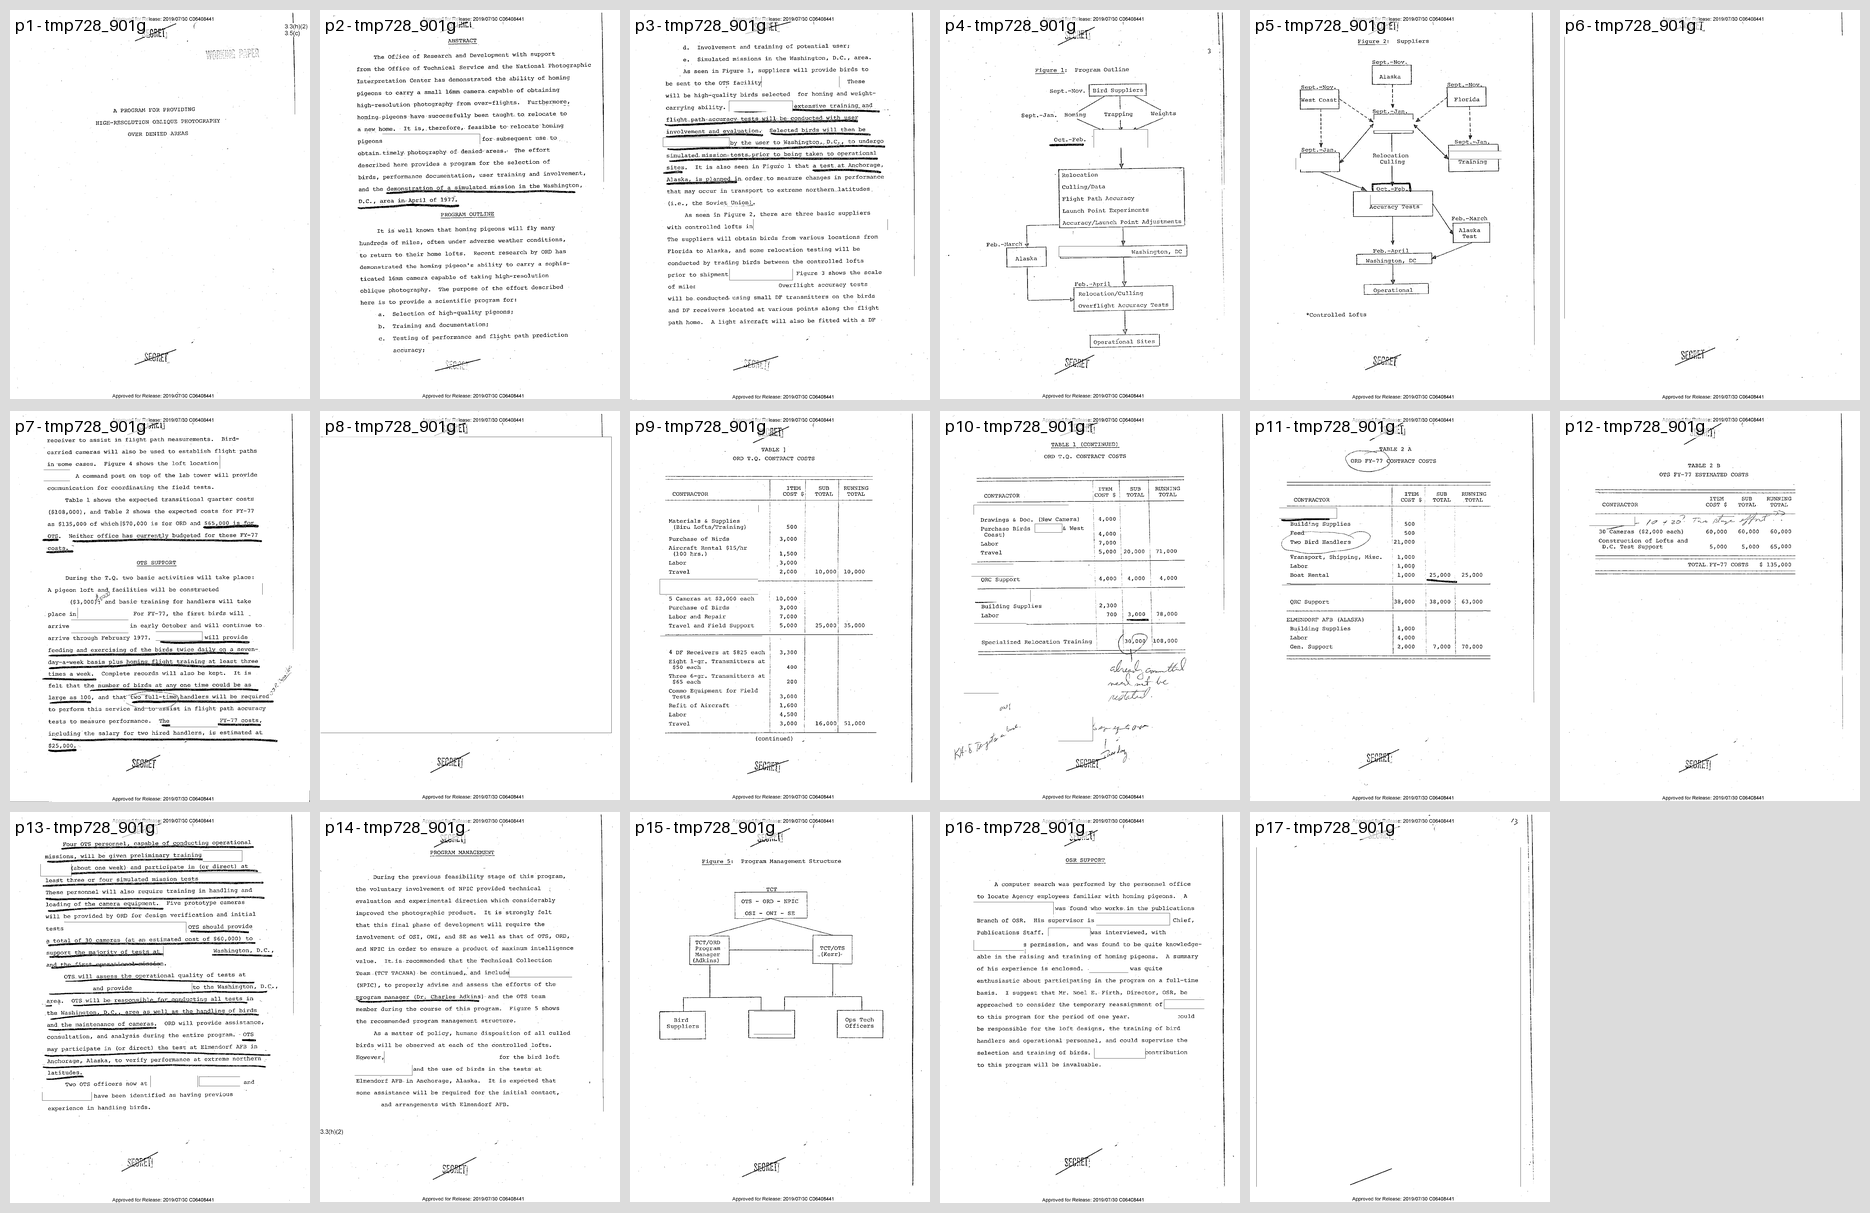

In [2]:
from natural_pdf import PDF

pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/cia-doc.pdf")
pdf.pages.to_image(cols=6)

## Vision classification

These pages are easily differentiable based on how they *look*, so we can most likely use a vision model to tell them apart.

In [3]:
pdf.classify_pages(['diagram', 'text', 'invoice', 'blank'], using='vision')

for page in pdf.pages:
    print(f"Page {page.number} is {page.category} - {page.category_confidence:0.3}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Device set to use mps:0


Classifying batch (openai/clip-vit-base-patch16):   0%|          | 0/17 [00:00<?, ?it/s]

Page 1 is text - 0.633
Page 2 is text - 0.957
Page 3 is text - 0.921
Page 4 is diagram - 0.895
Page 5 is diagram - 0.891
Page 6 is invoice - 0.919
Page 7 is text - 0.834
Page 8 is invoice - 0.594
Page 9 is invoice - 0.971
Page 10 is invoice - 0.987
Page 11 is invoice - 0.994
Page 12 is invoice - 0.992
Page 13 is text - 0.822
Page 14 is text - 0.936
Page 15 is diagram - 0.913
Page 16 is text - 0.617
Page 17 is invoice - 0.868


How did it do?

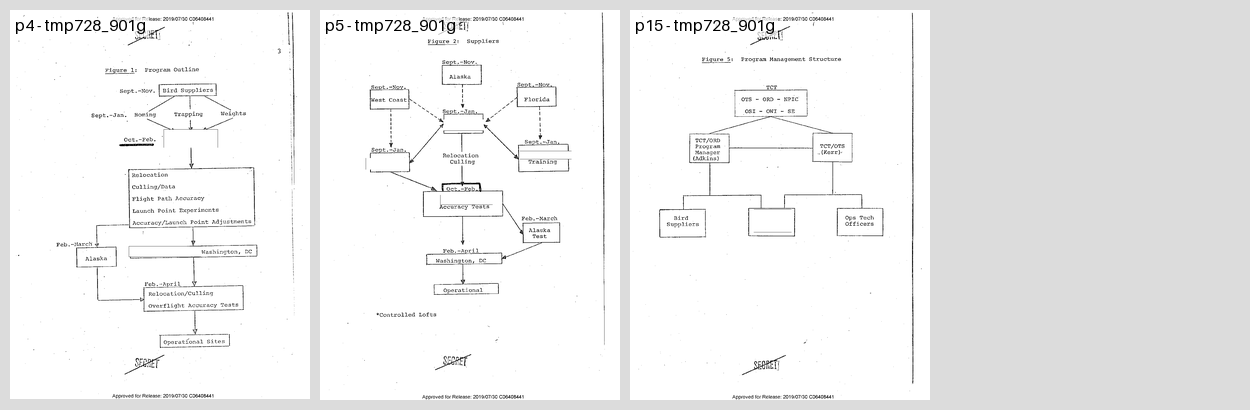

In [4]:
(
    pdf.pages
    .filter(lambda page: page.category == 'diagram')
    .to_image(show_category=True)
)

Looks great! Note that **I had to play around with the categories a bit** before I got something that worked. Using "blank" doesn't ever show up, "invoice" did a lot better than "form," etc etc. It's pretty quick and easy to sanity check so you shouldn't have to suffer too much.

I can also save just those pages into a new PDF document.

In [5]:
(
    pdf.pages
    .filter(lambda page: page.category == 'diagram')
    .save_pdf("output.pdf", original=True)
)

## Text classification (default)

By default the search is done using **text**. It takes the text on the page and feeds it to the classifier along with the categories. Note that you might need to OCR your content first!

In [6]:
pdf.classify_pages(['diagram', 'text', 'invoice', 'blank'], using='text')

for page in pdf.pages:
    print(f"Page {page.number} is {page.category} - {page.category_confidence:0.3}")

Device set to use mps:0


Classifying batch (facebook/bart-large-mnli):   0%|          | 0/17 [00:00<?, ?it/s]

Page 1 is text - 0.514
Page 2 is text - 0.587
Page 3 is invoice - 0.603
Page 4 is diagram - 0.65
Page 5 is diagram - 0.567
Page 6 is text - 0.654
Page 7 is diagram - 0.466
Page 8 is text - 0.626
Page 9 is text - 0.513
Page 10 is text - 0.542
Page 11 is invoice - 0.506
Page 12 is text - 0.78
Page 13 is text - 0.456
Page 14 is diagram - 0.721
Page 15 is diagram - 0.8
Page 16 is text - 0.499
Page 17 is text - 0.78


How does it compare to our vision option?

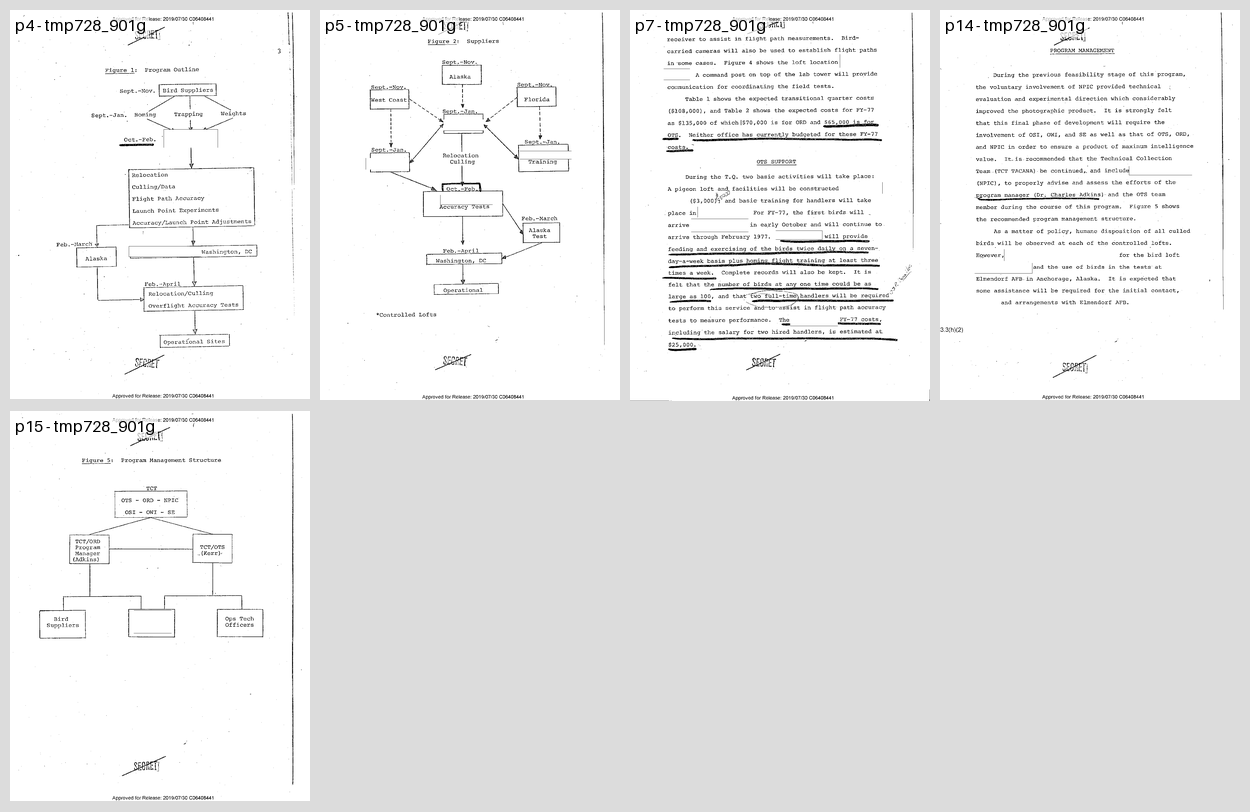

In [7]:
pdf.pages.filter(lambda page: page.category == 'diagram').to_image(show_category=True)

Yes, you can notice that it's *wrong*, but more importantly **look at the confidence scores**. Low scores are your best clue that something might not be perfect (beyond manually checking things, of course).

If you're processing documents that are text-heavy you'll have much better luck with a text model as compared to a vision one.

## PDF classification

If you want to classify entire PDFs, the process is similar. The only gotcha is you can't use `using="vision"` with multi-page PDFs (yet?).

In [8]:
import natural_pdf

pdf_paths = [
    "https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf",
    "https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/Atlanta_Public_Schools_GA_sample.pdf"
]

# Import your PDFs
pdfs = natural_pdf.PDFCollection(pdf_paths)

# Run your classification
pdfs.classify_all(['school', 'business'], using='text')

Loading PDFs:   0%|          | 0/2 [00:00<?, ?it/s]

[2025-06-10 17:27:07,100] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:27:07,228] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:27:07,229] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:27:07,230] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:27:07,230] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


[2025-06-10 17:27:07,231] [ WARNING] pdfpage.py:202 - CropBox missing from /Page, defaulting to MediaBox


Classifying PDFs (using='text'):   0%|          | 0/2 [00:00<?, ?pdf/s]

<PDFCollection(count=2)>

What's the first PDF?

business - confidence of 0.837


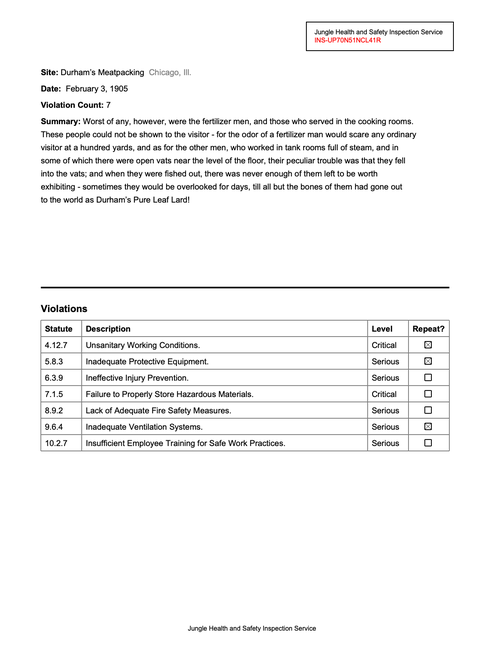

In [9]:
print(f"{pdfs[0].category} - confidence of {pdfs[0].category_confidence:0.3}")

# Look at the first page
pdfs[0].pages[0].to_image(width=500)

How about the second?

school - confidence of 0.569


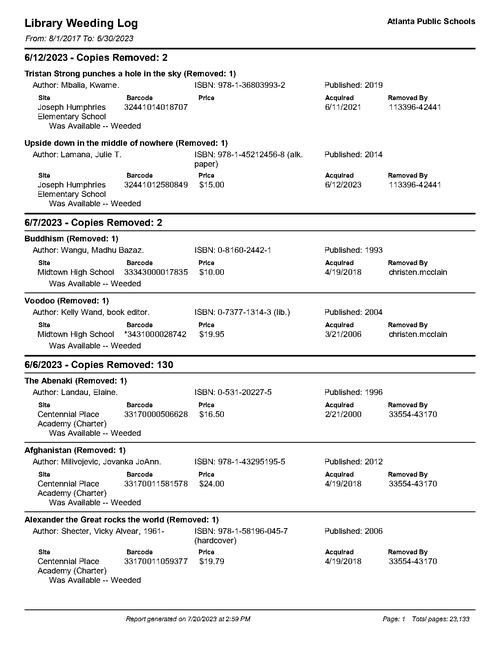

In [10]:
print(f"{pdfs[1].category} - confidence of {pdfs[1].category_confidence:0.3}")

# Look at the first page
pdfs[1].pages[0].to_image(width=500)